In [1]:
from common import *
disable_fig_save = False 
save_loc = 'plots'
save_prefix="pathfinding"
config_common(disable_fig_save=disable_fig_save, save_loc=save_loc, save_prefix=save_prefix)
from colors import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

%config InlineBackend.figure_format = 'svg'

from os import path
from typing import Dict, List, Set

import matplotlib.ticker as mtick
import matplotlib as mpl
from scipy.stats.mstats import gmean
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter, LogLocator)
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
from matplotlib import rc

import seaborn as sns

In [3]:
init_notebook()
figsize = (7,2)
fontsize = 11
Fig.config(fontsize, figsize)

In [4]:
dataf = "../../data/simplekv.csv"

In [5]:
!sha256sum $dataf

c76092e1ab1e451a30da455828ba27d040eee93c0103c7d51f34f6d4ac71049c  ../../data/simplekv.csv


In [6]:
def prefix_list(l, prefix):
    return [prefix + elem for elem in l]

In [7]:
df_raw = pd.read_csv(dataf, index_col=None)
print(df_raw)
index_vals =  ['a', 'b', 'c', 'd', 'e', 'f', 'g']
index_nv = prefix_list(index_vals, 'nv_')
index_v = prefix_list(index_vals, 'v_')
index_ua = prefix_list(index_vals, 'ua_')
index_comb = index_v + ['drop'] + index_nv + ['drop'] + index_ua
df_raw.index = index_comb
df_raw = df_raw.T
del df_raw['drop']
df_raw = df_raw.T

                 pmdk     snashot       msync  msync huge page  famus snap
0          3395219919  2746634549  3568598163      51744469415         NaN
1          2712134412  2352040633  2576410427       7301145977         NaN
2          2615253719  2305910338  2377482774       2306374389         NaN
3          4643941619  4209932124  5175347519      20420826946         NaN
4           204717907   152414071   311400368       5877676783         NaN
5          4220877269  3447483235  4324563492      52381774201         NaN
6          4136862606  3293300754  4606938151     100327086846         NaN
7                pmdk     snashot       msync  msync huge page  famus snap
8          3435318407  2860154354  3593656206      51533690293         NaN
9          2737946717  2403810531  2610177186       7344258938         NaN
10         2630088569  2355815108  2407674924       2328781685         NaN
11         4691533966  4283983618  5180450814      20216933657         NaN
12          203901626   1

In [8]:
v = (df_raw.T[index_v]).T[['pmdk', 'snashot', 'msync', 'msync huge page']]
v.index = index_vals
v

,pmdk,snashot,msync,msync huge page
a,3395219919,2746634549,3568598163,51744469415
b,2712134412,2352040633,2576410427,7301145977
c,2615253719,2305910338,2377482774,2306374389
d,4643941619,4209932124,5175347519,20420826946
e,204717907,152414071,311400368,5877676783
f,4220877269,3447483235,4324563492,52381774201
g,4136862606,3293300754,4606938151,100327086846


In [9]:
nv = (df_raw.T[index_nv]).T['snashot']
nv.index = index_vals
nv

a    2860154354
b    2403810531
c    2355815108
d    4283983618
e     167304363
f    3593962654
g    3466541973
Name: snashot, dtype: object

In [10]:
ua = (df_raw.T[index_ua]).T['pmdk']
ua.index = index_vals
ua

a    2940509182
b    2389696188
c    2313164136
d    4247634250
e     160471111
f    3458490056
g    3716895950
Name: pmdk, dtype: object

In [11]:
df = pd.DataFrame()
df['PMDK'] = np.int_(v['pmdk'])
df['Snapy-V'] = np.int_(v['snashot'])
df['Snapy-NV'] = np.int_(nv)
df['Snapy-V + unaligned'] = np.int_(ua)
df['msync (4KiB)'] = np.int_(v['msync'])
df['msync (2MiB)'] = np.int_(v['msync huge page'])
df.index = [val.capitalize() for val in index_vals]
df

,PMDK,Snapy-V,Snapy-NV,Snapy-V + unaligned,msync (4KiB),msync (2MiB)
A,3395219919,2746634549,2860154354,2940509182,3568598163,51744469415
B,2712134412,2352040633,2403810531,2389696188,2576410427,7301145977
C,2615253719,2305910338,2355815108,2313164136,2377482774,2306374389
D,4643941619,4209932124,4283983618,4247634250,5175347519,20420826946
E,204717907,152414071,167304363,160471111,311400368,5877676783
F,4220877269,3447483235,3593962654,3458490056,4324563492,52381774201
G,4136862606,3293300754,3466541973,3716895950,4606938151,100327086846


In [12]:
pmdk_col = df['PMDK']
df_norm = df.copy(deep=True)
for col in df:
    df_norm[col] = df[col]/pmdk_col
df_norm

,PMDK,Snapy-V,Snapy-NV,Snapy-V + unaligned,msync (4KiB),msync (2MiB)
A,1.0,0.808971,0.842406,0.866073,1.051065,15.240388
B,1.0,0.867229,0.886317,0.881113,0.949957,2.692030
C,1.0,0.881716,0.900798,0.884489,0.909083,0.881893
D,1.0,0.906543,0.922489,0.914661,1.114430,4.397305
E,1.0,0.744508,0.817243,0.783865,1.521119,28.711102
F,1.0,0.816769,0.851473,0.819377,1.024565,12.410163
G,1.0,0.796087,0.837964,0.898482,1.113631,24.251975


In [13]:
Fig.config(12, (8.2, 2.1))

In [14]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

In [15]:
new_labels = r"""\textbf{Workloads:}
\textbf{A)} R: 50, W: 50    \textbf{B)} R: 95, W: 5    \textbf{C)} R: 100 \textbf{D)} Read latest \textbf{E)} Read-modify-write
\textbf{G)} Short range scan \textbf{D)} W: 100"""


Plot saved as `plots/pathfinding/simplekv.png`

Plot saved as `plots/pathfinding/simplekv.png`

Using pdfcrop on `plots/pathfinding/simplekv.png` with command `pdfcrop plots/pathfinding/simplekv.pdf plots/pathfinding/simplekv.pdf`

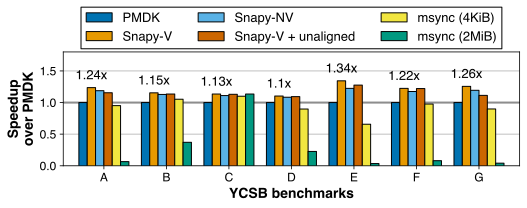

In [16]:
speedup = 1/df_norm
ax = speedup.plot.bar(**Fig.get_kwargs(width=0.8))
f = Fig(ax)
ax.set_ylim((0, 1.8))

f.fmt_legend(fontsize=fontsize+2)
# f.fmt_label('YCSB benchmarks', 'Relative performance')
f.fmt_label('YCSB benchmarks', 'Speedup\nover PMDK', fontsize=fontsize+3)
f.add_bar_labels([False, True, False, False, False, False], precision=2, fontsize=fontsize+2, over_fig=False, alpha=0)
f.xrot(rot=0)
f.fmt_grid(axis='y')
ax.set_yticks(np.arange(0, 1.8, 0.5))
ax.axline((0, 1), (10, 1), zorder=0, color='black')
# txt = ax.text(-0.55, -1.3, new_labels, fontsize=fontsize+2, color='black', bbox=dict(facecolor='none', edgecolor='black'), usetex=True, linespacing=1.1)
save_fig('simplekv')

### df_norm